In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

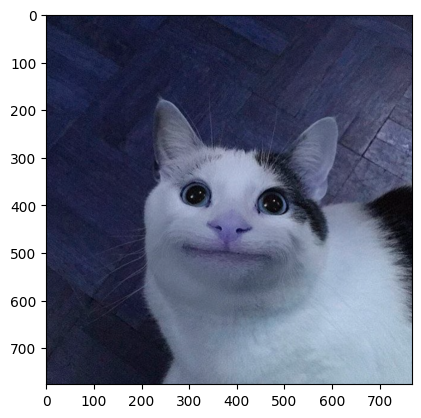

In [5]:
# openCV читает как BGR
image = cv2.imread('./image.png')
plt.imshow(image);

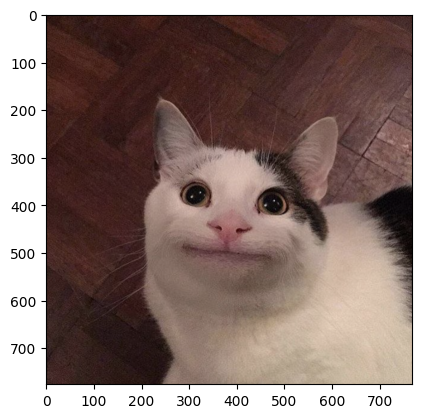

In [6]:
# делаем RGB
image_ex = image[...,::-1]
plt.imshow(image_ex)

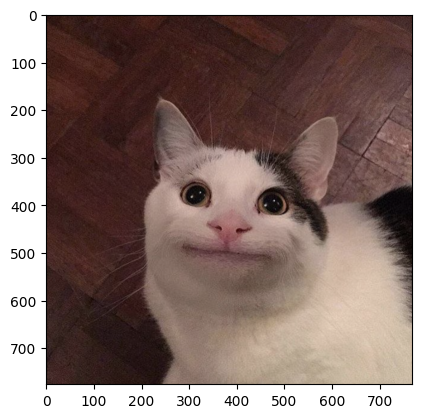

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

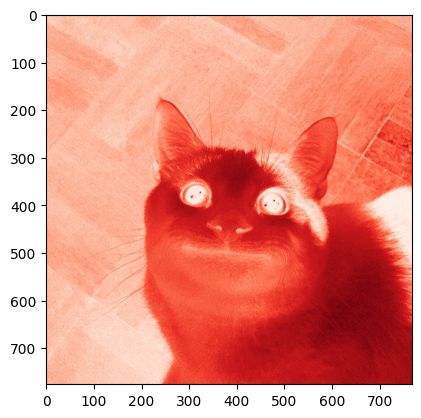

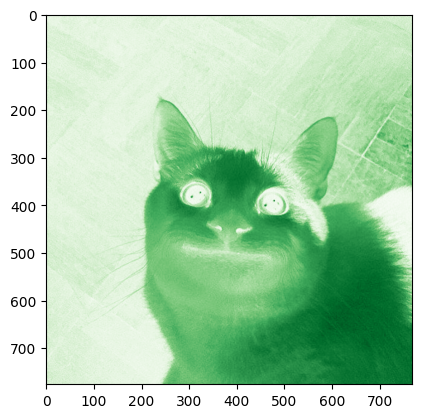

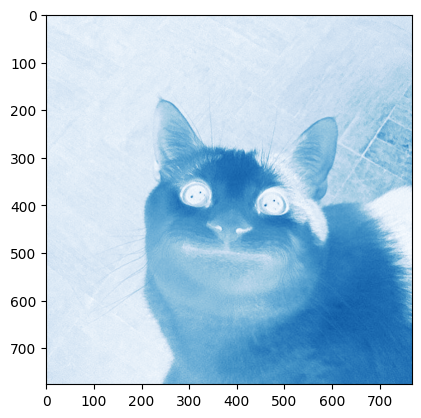

In [5]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


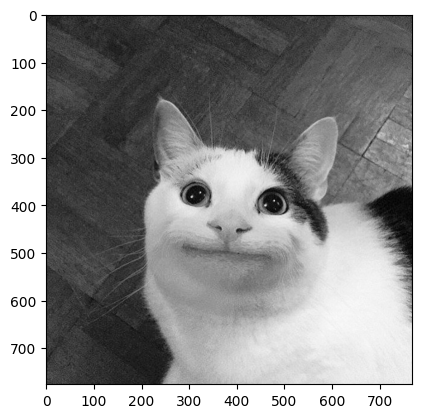

In [16]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [7]:
# !pip3 install scipy

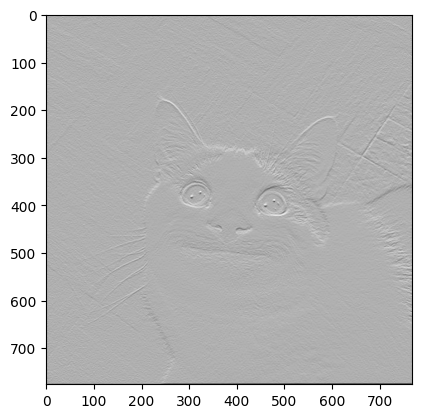

In [23]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

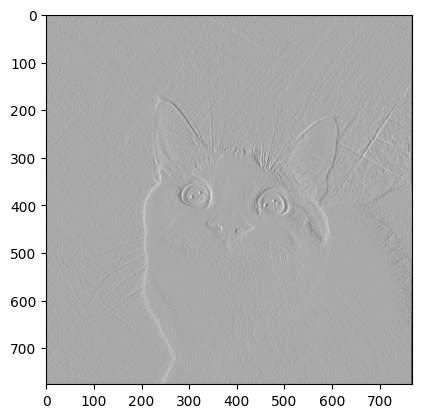

In [24]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

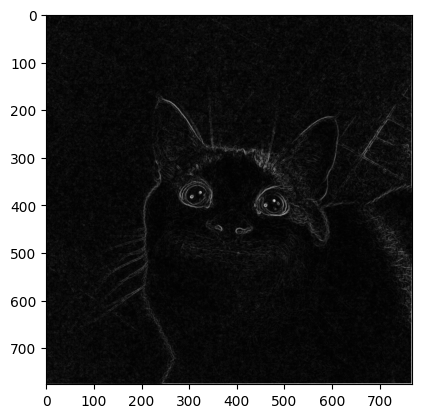

In [25]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [33]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [34]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [35]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [36]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [53]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [54]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [55]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [57]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './MNIST',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './MNIST',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

100%|███████████████████████████████████████| 9.91M/9.91M [00:12<00:00, 777kB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 166kB/s]
100%|███████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 874kB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.00MB/s]


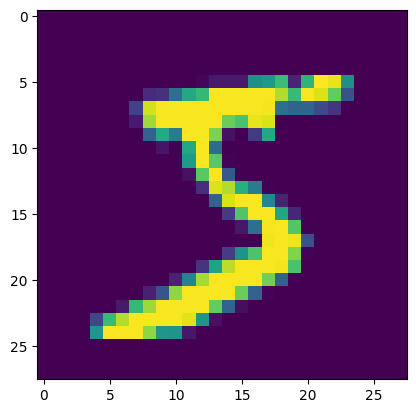

In [58]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [60]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [61]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [62]:
train(model, optimizer)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 260.98it/s]


Epoch: 0, loss: 0.321257084608078, accuracy: 0.9112


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 268.78it/s]


Epoch: 2, loss: 0.2314472496509552, accuracy: 0.9343


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 269.01it/s]

Epoch: 4, loss: 0.1857900470495224, accuracy: 0.9458


In [67]:
0.9462

0.9462

In [83]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [64]:
train(model, optimizer)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 206.07it/s]


Epoch: 0, loss: 0.26648473739624023, accuracy: 0.9207


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 209.39it/s]


Epoch: 2, loss: 0.1030239388346672, accuracy: 0.9688


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 205.72it/s]

Epoch: 4, loss: 0.07782796025276184, accuracy: 0.9754


In [66]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [110]:
def train_with_logging(model, optimizer, loss_func, n_epochs=5):    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(n_epochs):
        train_loss_epoch = []
        train_correct = 0
        train_total = 0
        
        for x_train, y_train in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]'):
            y_pred = model(x_train)
            loss = loss_func(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_epoch.append(loss.item())
            pred = y_pred.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(y_train.view_as(pred)).sum().item()
            train_total += y_train.size(0)
        
        val_loss_epoch = []
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{n_epochs} [Val]'):
                y_pred = model(x_val)
                loss = loss_func(y_pred, y_val)
                
                val_loss_epoch.append(loss.item())
                pred = y_pred.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(y_val.view_as(pred)).sum().item()
                val_total += y_val.size(0)
        
        train_losses.append(np.mean(train_loss_epoch))
        train_accuracies.append(train_correct / train_total)
        val_losses.append(np.mean(val_loss_epoch))
        val_accuracies.append(val_correct / val_total)

        print(f'Epoch: {epoch}, loss: {val_losses[-1]:.4f}, accuracy: {val_accuracies[-1]:.4f}')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [112]:
def mse_loss(output, target):
    target_one_hot = F.one_hot(target, num_classes=10).float()
    output_softmax = F.softmax(output, dim=1)
    return F.mse_loss(output_softmax, target_one_hot)

def plot_metrics(values, title, ylabel):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(values) + 1)
    plt.plot(epochs, values, 'b-o', linewidth=2, markersize=6)
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#### Бейзлайн 

In [78]:
res = train_with_logging(model, optimizer, F.cross_entropy)

Epoch 1/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 207.18it/s]


Epoch: 0, loss: 0.0361, accuracy: 0.9883


Epoch 2/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 208.57it/s]


Epoch: 1, loss: 0.0386, accuracy: 0.9868


Epoch 3/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 209.25it/s]


Epoch: 2, loss: 0.0369, accuracy: 0.9868


Epoch 4/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 203.04it/s]


Epoch: 3, loss: 0.0387, accuracy: 0.9868


Epoch 5/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 160.85it/s]

Epoch: 4, loss: 0.0358, accuracy: 0.9885


#### Два свёрточных слоя, небольшое число фильтров.
Попробуем размер ядра для свёртки = 3 и 5. В качестве оптимизатора будем использовать Adam. 
В качестве лосса – mse_loss 

In [105]:
model21 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),  
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(5*5*32, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer21 = torch.optim.Adam(model21.parameters(), lr=0.001)

res21 = train_with_logging(model21, optimizer21, mse_loss)

Epoch 1/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 238.48it/s]


Epoch: 0, loss: 0.0033, accuracy: 0.9790


Epoch 2/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 248.45it/s]


Epoch: 1, loss: 0.0024, accuracy: 0.9841


Epoch 3/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 248.49it/s]


Epoch: 2, loss: 0.0023, accuracy: 0.9848


Epoch 4/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 198.91it/s]


Epoch: 3, loss: 0.0018, accuracy: 0.9878


Epoch 5/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 245.85it/s]

Epoch: 4, loss: 0.0017, accuracy: 0.9885


In [104]:
model22 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4*4*32, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer22 = torch.optim.Adam(model22.parameters(), lr=0.001)

res22 = train_with_logging(model22, optimizer22, mse_loss)

Epoch 1/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 240.94it/s]


Epoch: 0, loss: 0.0036, accuracy: 0.9765


Epoch 2/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 176.34it/s]


Epoch: 1, loss: 0.0016, accuracy: 0.9899


Epoch 3/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 239.21it/s]


Epoch: 2, loss: 0.0019, accuracy: 0.9875


Epoch 4/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 242.12it/s]


Epoch: 3, loss: 0.0015, accuracy: 0.9898


Epoch 5/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 238.91it/s]

Epoch: 4, loss: 0.0015, accuracy: 0.9906


#### Попробуем большее число фильтров + 2 свёрточных слоя
В качестве лосса сначала попробуем mse_loss, а потом negative log-likelihood

In [103]:
model31 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(7*7*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
optimizer31 = torch.optim.Adam(model31.parameters(), lr=0.001)

res31 = train_with_logging(model31, optimizer31, mse_loss)

Epoch 1/5 [Val]: 100%|████████████████████████| 157/157 [00:02<00:00, 69.00it/s]


Epoch: 0, loss: 0.0025, accuracy: 0.9840


Epoch 2/5 [Val]: 100%|████████████████████████| 157/157 [00:02<00:00, 69.29it/s]


Epoch: 1, loss: 0.0019, accuracy: 0.9870


Epoch 3/5 [Val]: 100%|████████████████████████| 157/157 [00:02<00:00, 64.60it/s]


Epoch: 2, loss: 0.0019, accuracy: 0.9879


Epoch 4/5 [Val]: 100%|████████████████████████| 157/157 [00:02<00:00, 68.16it/s]


Epoch: 3, loss: 0.0016, accuracy: 0.9895


Epoch 5/5 [Val]: 100%|████████████████████████| 157/157 [00:02<00:00, 68.19it/s]

Epoch: 4, loss: 0.0019, accuracy: 0.9888


In [102]:
model32 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(7*7*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)
optimizer32 = torch.optim.Adam(model32.parameters(), lr=0.001)

res32 = train_with_logging(model32, optimizer32, F.nll_loss)

Epoch 1/5 [Val]: 100%|████████████████████████| 157/157 [00:04<00:00, 33.55it/s]


Epoch: 0, loss: 0.0463, accuracy: 0.9858


Epoch 2/5 [Val]: 100%|████████████████████████| 157/157 [00:04<00:00, 32.90it/s]


Epoch: 1, loss: 0.0340, accuracy: 0.9889


Epoch 3/5 [Val]: 100%|████████████████████████| 157/157 [00:04<00:00, 35.25it/s]


Epoch: 2, loss: 0.0361, accuracy: 0.9872


Epoch 4/5 [Val]: 100%|████████████████████████| 157/157 [00:04<00:00, 32.82it/s]


Epoch: 3, loss: 0.0329, accuracy: 0.9894


Epoch 5/5 [Val]: 100%|████████████████████████| 157/157 [00:04<00:00, 36.00it/s]

Epoch: 4, loss: 0.0390, accuracy: 0.9902


NLL оказался лучше чем mse_loss для большего числа фильтров. Но model22, у которой размер ядра = 5, пока выигрывает.
Попробуем NLL для model22, а также увеличим число фильтров

In [107]:
model41 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4*4*32, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer41 = torch.optim.Adam(model41.parameters(), lr=0.001)

res41 = train_with_logging(model41, optimizer41, F.nll_loss)

Epoch 1/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 240.02it/s]


Epoch: 0, loss: 0.0568, accuracy: 0.9818


Epoch 2/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 235.48it/s]


Epoch: 1, loss: 0.0331, accuracy: 0.9893


Epoch 3/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 233.35it/s]


Epoch: 2, loss: 0.0385, accuracy: 0.9879


Epoch 4/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 240.36it/s]


Epoch: 3, loss: 0.0367, accuracy: 0.9880


Epoch 5/5 [Val]: 100%|███████████████████████| 157/157 [00:00<00:00, 236.03it/s]

Epoch: 4, loss: 0.0374, accuracy: 0.9879


In [108]:
model42 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5),  
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4*4*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
optimizer42 = torch.optim.Adam(model42.parameters(), lr=0.001)

res42 = train_with_logging(model42, optimizer42, mse_loss)

Epoch 1/5 [Val]: 100%|████████████████████████| 157/157 [00:01<00:00, 88.31it/s]


Epoch: 0, loss: 0.0025, accuracy: 0.9841


Epoch 2/5 [Val]: 100%|████████████████████████| 157/157 [00:01<00:00, 79.05it/s]


Epoch: 1, loss: 0.0014, accuracy: 0.9909


Epoch 3/5 [Val]: 100%|████████████████████████| 157/157 [00:01<00:00, 84.49it/s]


Epoch: 2, loss: 0.0018, accuracy: 0.9886


Epoch 4/5 [Val]: 100%|████████████████████████| 157/157 [00:01<00:00, 88.30it/s]


Epoch: 3, loss: 0.0019, accuracy: 0.9885


Epoch 5/5 [Val]: 100%|████████████████████████| 157/157 [00:01<00:00, 89.50it/s]

Epoch: 4, loss: 0.0016, accuracy: 0.9905


А если будет больше эпох

In [111]:
model42 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5),  
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4*4*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
optimizer42 = torch.optim.Adam(model42.parameters(), lr=0.001)

res42 = train_with_logging(model=model42, optimizer=optimizer42, loss_func=mse_loss, n_epochs=10)

Epoch 1/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 89.37it/s]


Epoch: 0, loss: 0.0021, accuracy: 0.9861


Epoch 2/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 84.63it/s]


Epoch: 1, loss: 0.0025, accuracy: 0.9838


Epoch 3/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 85.02it/s]


Epoch: 2, loss: 0.0019, accuracy: 0.9875


Epoch 4/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 86.80it/s]


Epoch: 3, loss: 0.0033, accuracy: 0.9797


Epoch 5/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 89.74it/s]


Epoch: 4, loss: 0.0017, accuracy: 0.9897


Epoch 6/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 90.02it/s]


Epoch: 5, loss: 0.0020, accuracy: 0.9878


Epoch 7/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 88.02it/s]


Epoch: 6, loss: 0.0014, accuracy: 0.9915


Epoch 8/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 91.51it/s]


Epoch: 7, loss: 0.0015, accuracy: 0.9918


Epoch 9/10 [Val]: 100%|███████████████████████| 157/157 [00:01<00:00, 89.62it/s]


Epoch: 8, loss: 0.0016, accuracy: 0.9907


Epoch 10/10 [Val]: 100%|██████████████████████| 157/157 [00:01<00:00, 89.27it/s]

Epoch: 9, loss: 0.0014, accuracy: 0.9917


In [120]:
def info_for_model(model, res, model_num):
    plot_metrics(res[2], f'Loss for model{model_num}', 'Loss')
    plot_metrics(res[3], f'Accuracy for model{model_num}', 'Accuracy')
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Кол-во обучаемых параметров: {total_params}")

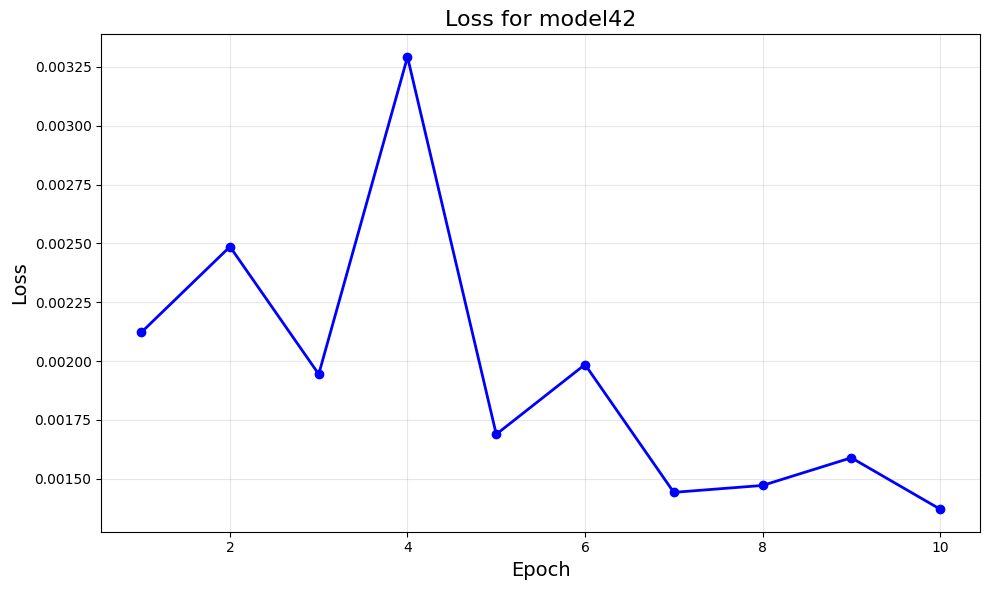

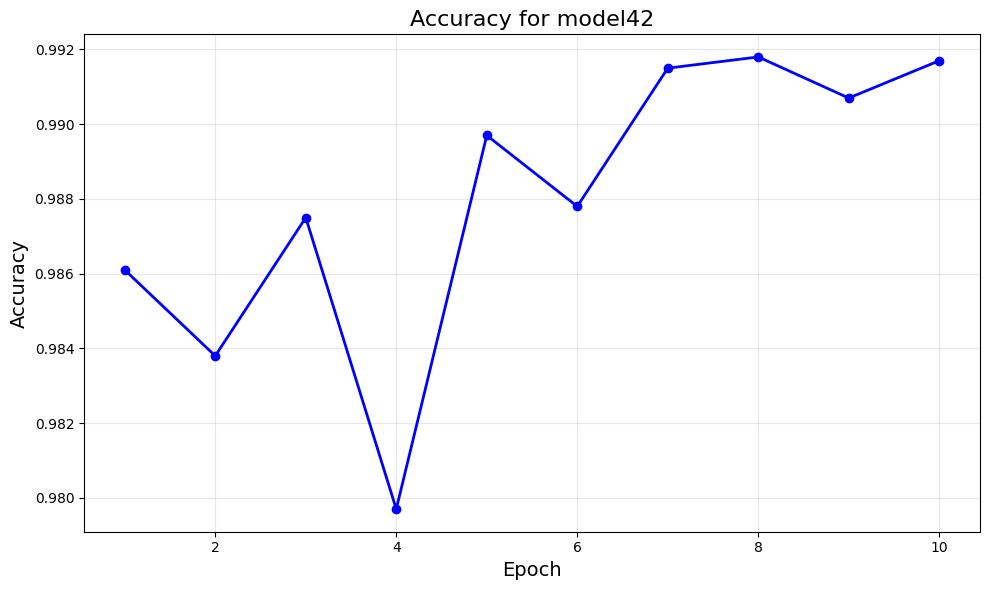

Кол-во обучаемых параметров: 733706


In [121]:
info_for_model(model42, res42, 42)

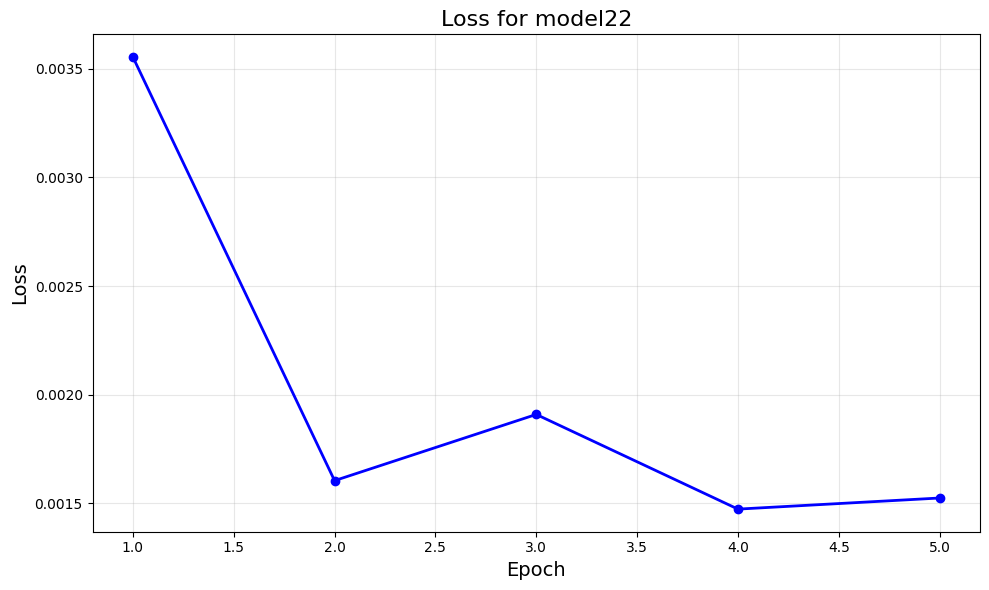

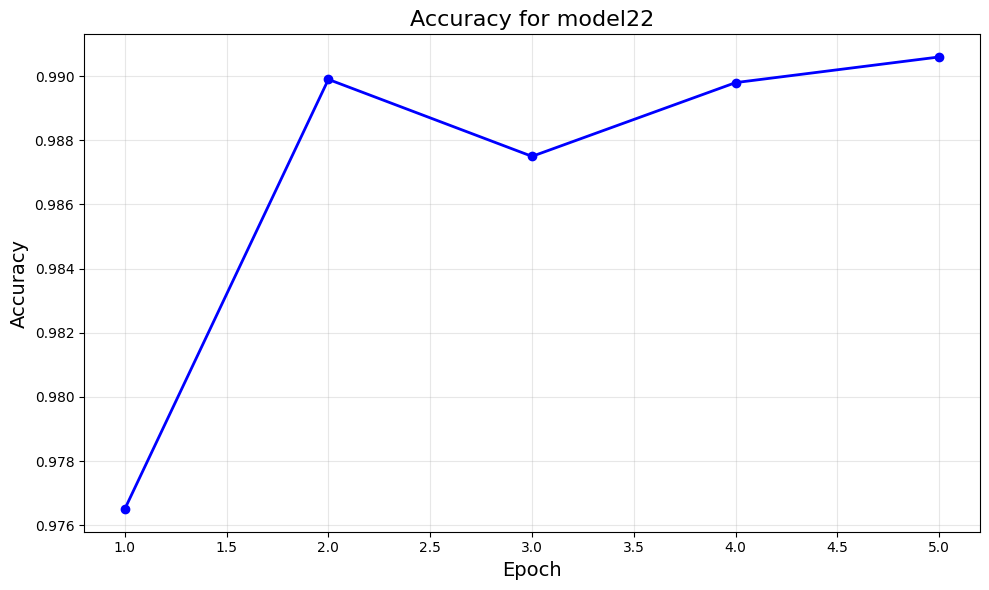

Кол-во обучаемых параметров: 80202


In [122]:
info_for_model(model22, res22, 22)

Кол-во обучаемых параметров у model42 в 9 раз больше чем у model22, а loss и accuracy не сильно отличаются

Построим теперь график среднего лосса и accuracy на всём обучении для каждой модели

In [128]:
res_loss, res_acc = np.mean(res[2]), np.mean(res[3])
res21_loss, res21_acc = np.mean(res21[2]), np.mean(res21[3])
res22_loss, res22_acc = np.mean(res22[2]), np.mean(res22[3])
res31_loss, res31_acc = np.mean(res31[2]), np.mean(res31[3])
res32_loss, res32_acc = np.mean(res32[2]), np.mean(res32[3])
res41_loss, res41_acc = np.mean(res41[2]), np.mean(res41[3])
res42_loss, res42_acc = np.mean(res42[2]), np.mean(res42[3])

mean_losses = [res_loss, res21_loss, res22_loss, res31_loss, res32_loss, res41_loss, res42_loss]
mean_accuracy = [res_acc, res21_acc, res22_acc, res31_acc, res32_acc, res41_acc, res42_acc]

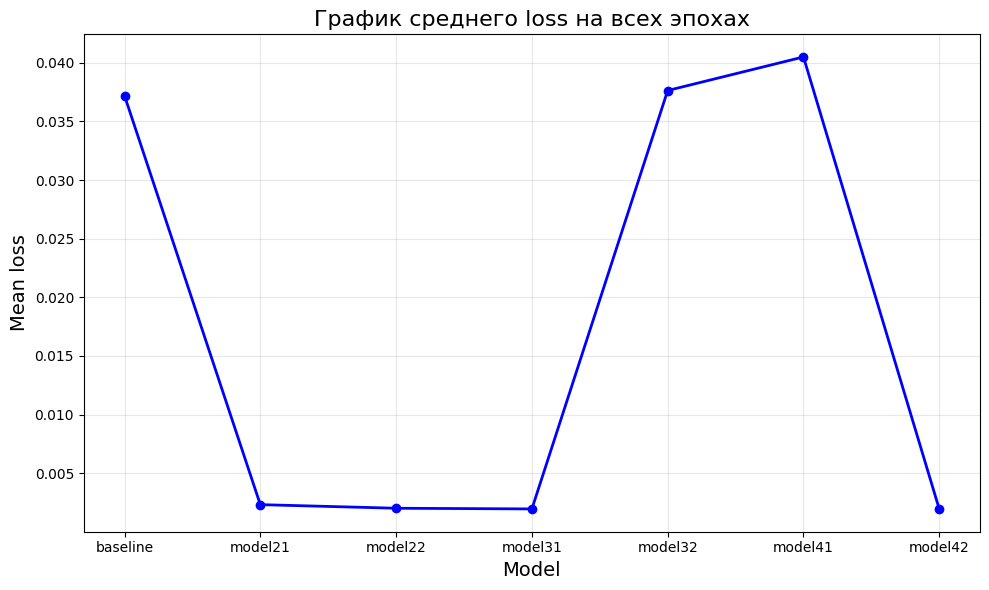

In [130]:
plt.figure(figsize=(10, 6))
models = ['baseline', 'model21', 'model22', 'model31', 'model32', 'model41', 'model42']
plt.plot(models, mean_losses, 'b-o', linewidth=2, markersize=6)
plt.title('График среднего loss на всех эпохах', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

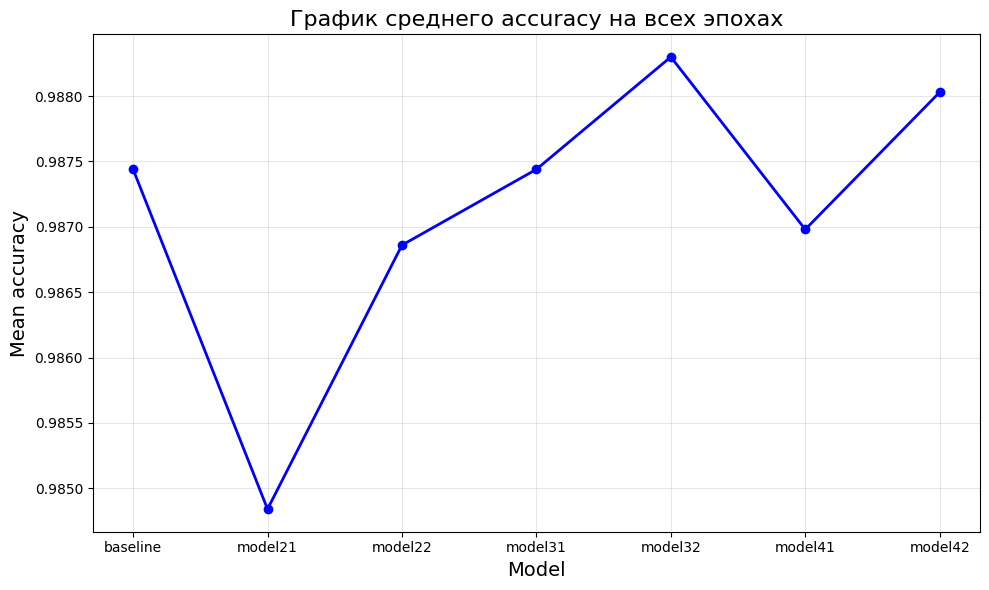

In [131]:
plt.figure(figsize=(10, 6))
models = ['baseline', 'model21', 'model22', 'model31', 'model32', 'model41', 'model42']
plt.plot(models, mean_accuracy, 'b-o', linewidth=2, markersize=6)
plt.title('График среднего accuracy на всех эпохах', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Выводы
1. Лучший accuracy имеет модель с большим числом out_channels для свёрток. Содержит 2 слоя Convolution + Max-pool. Обучается
   в течение 10 эпох. Не содержит padding, оптимизатор – Adam, причём он показал себя лучше чем SGD у baseline, а лосс – MSE.
2. Модели, имеющие kernel_size = 5, работают немного лучше. Сохранение размера для Convolution при помощи padding
   и его уменьшение при помощи Max-pool позволяет быстрее сойтись - model32 имеет наилучший Mean Accuracy.
3. Важную роль играет лосс, т.к. в случае NNLoss качество ухудшается. 
4. У моделей с большим числом out_channels много обучаемых параметров, что замедляет обучение модели 